In [766]:
import numpy as np
import pandas as pd
import tensorflow as tf
import copy as copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline
import os.path
import glob
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [767]:
os. chdir('/IBA/upwork/project1')
dff = pd.read_csv('output_data.csv')
dff.head

<bound method NDFrame.head of        mkt_id output_date  output_own_price  output_own_cost  \
0          44    1-Jan-19              7.05             5.90   
1          44    2-Jan-19              7.05             6.05   
2          44    3-Jan-19              7.05             5.98   
3          44    4-Jan-19              7.05             5.98   
4          44    5-Jan-19              6.79             6.07   
...       ...         ...               ...              ...   
19705   15555   27-Dec-19              7.28             5.96   
19706   15555   28-Dec-19              6.69             5.94   
19707   15555   29-Dec-19              6.69             5.91   
19708   15555   30-Dec-19              7.31             5.99   
19709   15555   31-Dec-19              7.28             6.05   

       output_comp_price  output_own_profits  output_X  output_own_share  \
0                   7.11           15.065000     42.80          0.515267   
1                   7.11           24.310000     

In [768]:
# def process_training_data(df):

#     grouped = df.groupby('mkt_id')

#     os. chdir('/IBA/upwork/project1/grouped')

#     for data in grouped.mkt_id:
#         print(data[0])
#         grouped.get_group(data[0]).to_excel(str(data[0])+".xlsx")

#     path = os.getcwd()
#     csv_files = glob.glob(os.path.join(path, "*.xlsx"))
#     print("Current working directory: {0}".format(path))


#     for f in csv_files:
    
#         # read the csv file
#         df = pd.read_excel(f)
#         df.drop(df.columns[0],axis = 1, inplace = True)
        
#         df.info

#         predictions = df['output_own_price']

#         df = df.drop(df.index[-1])
#         predictions = predictions.drop(predictions.index[0])

        
#         df.to_excel(f, index=False)

#         predictions.to_excel(f+"pred.xlsx", index=False)


In [769]:
def process_training_data(dff):

    dff.drop(dff.columns[0],axis = 1, inplace = True)
    dff.drop(dff.columns[0],axis = 1, inplace = True)

    predictionsdff = copy.deepcopy(dff['output_own_price'])

    for index in range(len(dff)):
        if index % 364 == 0 and index != len(dff):
            dff.drop(dff.index[index+364], inplace=True)

        if index % 364 == 0 and index != len(dff):
            predictionsdff.drop(predictionsdff.index[index],inplace=True)
    
    sns.pairplot(dff[['output_own_price', 'output_own_cost', 'output_comp_price', 'output_own_profits']], diag_kind='kde')
        
    print(dff.describe().transpose())

    df = dff.sample(frac=0.8, random_state=0)
    testdf = dff.drop(df.index)

    predictions = predictionsdff.sample(frac=0.8, random_state=0)
    testpredictions = predictionsdff.drop(predictions.index)
    
    df.to_excel("processed.xlsx", index=False)

    predictions.to_excel("pred.xlsx", index=False)

    testdf.to_excel("testdata.xlsx", index=False)

    testpredictions.to_excel("testpred.xlsx", index=False)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(df))
    first = np.array(df[:1])

    with np.printoptions(precision=2, suppress=True):
        print('First example:', first)
        print()
        print('Normalized:', normalizer(first).numpy())
    
    return df,predictions,normalizer,testpredictions,testdf


In [770]:
def train_model(df,predictions,normalizer,testdf,testpredictions):

    print(f"the shape of the training set (input) is: {df.shape}")
    print(f"the shape of the training set (target) is: {predictions.shape}\n")
    print(f"the shape of the test set (input) is: {testdf.shape}")
    print(f"the shape of the test set (target) is: {testpredictions.shape}")

    model = Sequential(
        [            
        normalizer,            
        Dense(64, activation='relu'), 
        Dense(64, activation='relu'),
        Dense(25, activation='relu'),
        Dense(15, activation='relu'), 
        
        Dense(1)  
        
        ],
        ) 
    model.summary()
    
    # L1_num_params = 7 * 64 + 25  # W1 parameters  + b1 parameters
    # L2_num_params = 25 * 15 + 15   # W2 parameters  + b2 parameters
    # L3_num_params = 15 * 1 + 1     # W3 parameters  + b3 parameters
    # print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params )

    [layer1, layer2, layer3,layer4,layer5,layer6] = model.layers

    #### Examine Weights shapes
    # W1,b1 = layer1.get_weights()
    W2,b2 = layer2.get_weights()
    W3,b3 = layer3.get_weights()
    W4,b4 = layer3.get_weights()

    # print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
    print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
    print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")
    print(f"W4 shape = {W4.shape}, b3 shape = {b4.shape}")

    model.compile(
        loss=tf.keras.losses.MeanAbsolutePercentageError(),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )
    
    bmw = model.fit(
        df,
        predictions,
        epochs=200,
        # Calculate validation results on 20% of the training data.
        validation_split = 0.2,
        )

    hist = pd.DataFrame(bmw.history)
    hist['epoch'] = bmw.epoch
    
    test_predictions = model.predict(testdf).flatten()

    figure, axis = plt.subplots(2, 2)
    figure.tight_layout(pad=1.0)

    axis[0, 0].plot(aspect='equal')
    axis[0, 0].scatter(testpredictions, test_predictions)
    axis[0, 0].set(xlabel='True Values')
    axis[0, 0].set(ylabel='Predictions')
    axis[0, 0].lims = [6.5,7.75 ]
    axis[0, 0].set(xlim=(axis[0, 0].lims))
    axis[0, 0].set(ylim=(axis[0, 0].lims))
    axis[0, 0].plot(axis[0, 0].lims, axis[0, 0].lims)

    error = test_predictions - testpredictions
    axis[0, 1].hist(error, bins=25)
    axis[0, 1].set(xlabel='Prediction Error')
    axis[0, 1].set(ylabel='Count')

    errorx = (test_predictions - testpredictions)/testpredictions*100
    axis[1, 1].hist(errorx, bins=25)
    axis[1, 1].set(xlabel='Prediction Error percentage')
    axis[1, 1].set(ylabel='Count')


    axis[1,0].plot(bmw.history['loss'], label='loss')
    axis[1,0].plot(bmw.history['val_loss'], label='val_loss')
    axis[1,0].set(ylim=[0, 0.01])
    axis[1,0].set(xlabel='Epoch')
    axis[1,0].set(ylabel='Error [output_own_price]')

    model.save('pred_model')
    plt.show()

    return model,hist

In [771]:
def predict_price(model,testdata):

    # testdata.drop(testdata.columns[0],axis = 1, inplace = True)
    # testdata.drop(testdata.columns[0],axis = 1, inplace = True)
    testtensor = tf.convert_to_tensor(testdata,  dtype=tf.float32)

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(testtensor))
    normalizer(testtensor).numpy()

    first = np.array(testtensor[:1])

    print(first)

    print(normalizer(first).numpy())

    testdatapredictions = model.predict(testtensor).flatten()
    predictionpd = pd.DataFrame (testdatapredictions)

    predictionpd.to_excel("testdatapredictionsfinal.xlsx", index=False)

    return predictionpd

    
    
    

                      count       mean        std        min        25%  \
output_own_price    19656.0   7.001498   0.202643   6.560000   6.780000   
output_own_cost     19656.0   5.999672   0.049679   5.790000   5.970000   
output_comp_price   19656.0   7.002646   0.200870   6.560000   6.790000   
output_own_profits  19656.0   8.426469   9.975373   0.012600   0.947300   
output_X            19656.0  52.772063  14.894983  24.620000  39.920000   
output_own_share    19656.0   0.499946   0.077910   0.193445   0.449985   
output_own_sales    19656.0   7.250788   7.817420   0.020000   1.050000   

                          50%        75%        max  
output_own_price     7.040000   7.150000   7.550000  
output_own_cost      6.000000   6.030000   6.230000  
output_comp_price    7.040000   7.150000   7.510000  
output_own_profits   3.519201  14.354550  53.029810  
output_X            51.440000  64.940000  92.840000  
output_own_share     0.500032   0.550129   0.800825  
output_own_sales     

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


394/394 [==============================] - 2s 3ms/step - loss: 7.1436 - val_loss: 2.2763
Epoch 2/200
394/394 [==============================] - 1s 2ms/step - loss: 2.5349 - val_loss: 2.8344
Epoch 3/200
394/394 [==============================] - 1s 2ms/step - loss: 2.5274 - val_loss: 2.2963
Epoch 4/200
394/394 [==============================] - 1s 2ms/step - loss: 2.2998 - val_loss: 1.9485
Epoch 5/200
394/394 [==============================] - 1s 2ms/step - loss: 2.1095 - val_loss: 2.4228
Epoch 6/200
394/394 [==============================] - 1s 2ms/step - loss: 2.1496 - val_loss: 1.8421
Epoch 7/200
394/394 [==============================] - 1s 2ms/step - loss: 2.1479 - val_loss: 1.8203
Epoch 8/200
394/394 [==============================] - 1s 2ms/step - loss: 2.0203 - val_loss: 2.5027
Epoch 9/200
394/394 [==============================] - 1s 2ms/step - loss: 2.0261 - val_loss: 1.8589
Epoch 10/200
394/394 [==============================] - 1s 2ms/step - loss: 1.8952 - val_loss: 1.7898
E

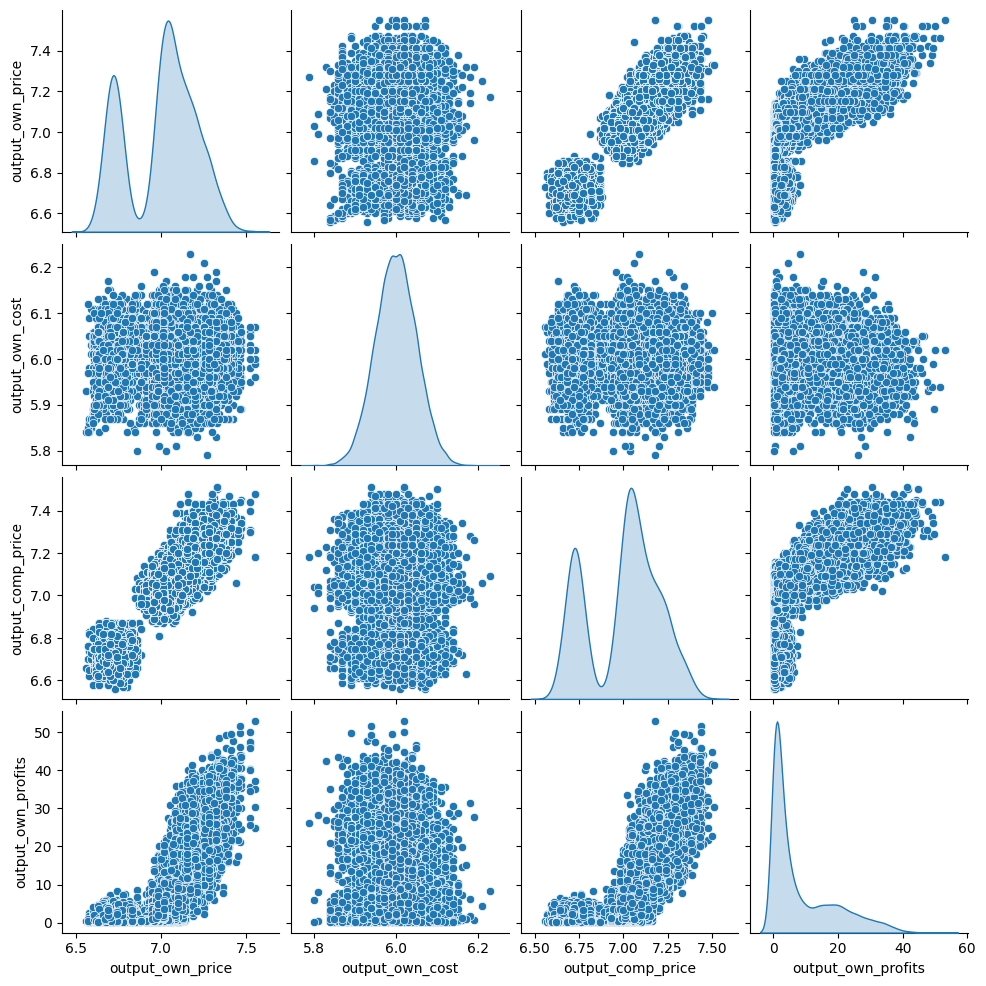

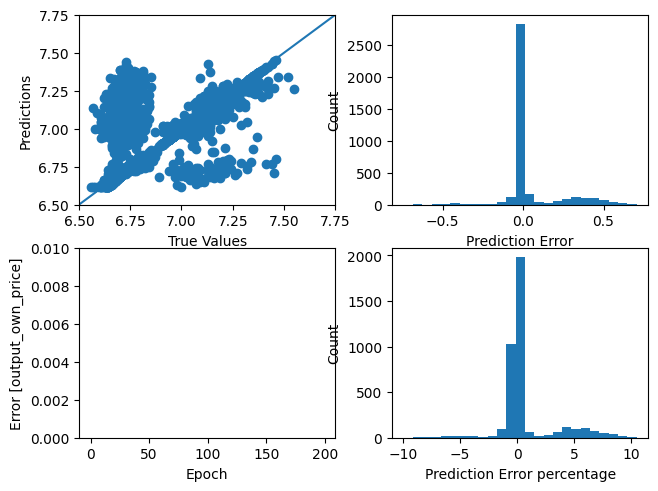

[[ 7.1        6.04       7.29      21.0622    40.1        0.5535361
  19.87     ]]
[[ 0.49384126  0.807982    1.45033     1.2982651  -0.8614294   0.6587599
   1.6394668 ]]
123/123 [==============================] - 0s 1ms/step


C:\Users\DELL\AppData\Local\Temp\ipykernel_16720\573906305.py:26: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  error = np.subtract(testpred,testdatapredictionsfinal)


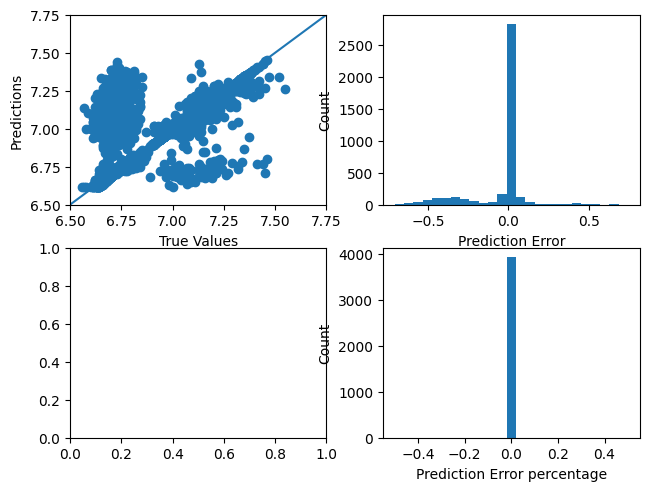

1.22


In [772]:
df,predictions,normalizer,testpredictions,testdf = process_training_data(dff)

model,hist = train_model(df,predictions,normalizer,testdf,testpredictions)

testdata  = pd.read_excel('testdata.xlsx')
testpred  = pd.read_excel('testpred.xlsx')

testdata.info
testdatapredictionsfinal=predict_price(model,testdata)
testpred.drop(dff.index[0], inplace=True)
testdatapredictionsfinal.drop(dff.index[0], inplace=True)


figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad=1.0)

axis[0, 0].plot(aspect='equal')
axis[0, 0].scatter(testpred, testdatapredictionsfinal)
axis[0, 0].set(xlabel='True Values')
axis[0, 0].set(ylabel='Predictions')
axis[0, 0].lims = [6.5,7.75 ]
axis[0, 0].set(xlim=(axis[0, 0].lims))
axis[0, 0].set(ylim=(axis[0, 0].lims))
axis[0, 0].plot(axis[0, 0].lims, axis[0, 0].lims)

error = np.subtract(testpred,testdatapredictionsfinal)

error.to_excel("error.xlsx", index=False)

axis[0, 1].hist(error, bins=25)
axis[0, 1].set(xlabel='Prediction Error')
axis[0, 1].set(ylabel='Count')

errorx = (testpred - testpred)/error*100
axis[1, 1].hist(errorx, bins=25)
axis[1, 1].set(xlabel='Prediction Error percentage')
axis[1, 1].set(ylabel='Count')

plt.show()

testpred, testdatapredictionsfinal = np.array(testpred), np.array(testdatapredictionsfinal)

MAPE = round(np.mean(np.abs((testpred - testdatapredictionsfinal) / testpred)) * 100, 2)

print(MAPE)
